In [ ]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class CustomSpeechCommands(Dataset):
    def __init__(self, root, files_list, download=S): # cambiar esto a true si no se tiene el dataset
        # Descargar el dataset completo si no existe
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root=root, 
            download=download
        )
        
        # Leer la lista de archivos de tu partición
        with open(files_list, 'r') as f:
            self.file_paths = [line.strip() for line in f.readlines()]
        
        print(f"Primeros 3 paths en {files_list}: {self.file_paths[:3]}")
        
        # Obtener todos los paths del dataset original y normalizarlos
        self.all_paths = []
        for item in self.dataset._walker:
            # Extraer solo la parte relativa del path
            full_path = item
            # Convertir a formato relativo (como en los archivos .txt)
            relative_path = os.path.relpath(full_path, start=os.path.join(root, "SpeechCommands", "speech_commands_v0.02"))
            relative_path = relative_path.replace("\\", "/")
            # En Windows, convertir barras invertidas a normales
            self.all_paths.append(relative_path)

        print(f"Primeros 3 paths normalizados del dataset: {self.all_paths[:3]}")
        
        # Crear máscara para filtrar los archivos de tu partición
        self.indices = [
            i for i, path in enumerate(self.all_paths) 
            if path in self.file_paths
        ]
        
        print(f"Total archivos en dataset: {len(self.all_paths)}")
        print(f"Archivos en {files_list}: {len(self.file_paths)}")
        print(f"Archivos encontrados: {len(self.indices)}")
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # Obtener el índice original en el dataset completo
        original_idx = self.indices[idx]
        waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[original_idx]
        return waveform, sample_rate, label, speaker_id, utterance_number

# Configuración
ROOT_DIR = "data"
TRAIN_LIST = os.path.join(ROOT_DIR,"train_list.txt")
VAL_LIST = os.path.join(ROOT_DIR, "val_list.txt")
TEST_LIST = os.path.join(ROOT_DIR, "test_list.txt")

# Verificar que los archivos de lista existen
for file_list in [TRAIN_LIST, VAL_LIST, TEST_LIST]:
    if not os.path.exists(file_list):
        print(f"Error: No se encuentra {file_list}")
    else:
        print(f"Encontrado: {file_list}")

# Crear directorio si no existe
os.makedirs(ROOT_DIR, exist_ok=True)

# Definir la transformación
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13, # número de coeficientes MFCC a extraer
    melkwargs={"n_fft": 320, "hop_length": 160, "n_mels": 23} # 320 = 20ms, 160 = 10ms, 23 = número de filtros mel
)

# Función para extraer características de un dataset
def extract_features(dataset):
    features = []
    labels = []
    for idx in range(len(dataset)):
        waveform, sample_rate, label, _, _ = dataset[idx]

        # aplicar transformación (ej: MFCC)
        feat = mfcc_transform(waveform).squeeze(0)  # (n_mfcc, time)
        
        features.append(feat.numpy())
        labels.append(label)
        
        if idx % 2000 == 0:  # solo para debug
            print(f"Procesado {idx}/{len(dataset)} muestras")
    
    return features, labels



Encontrado: data/train_list.txt
Encontrado: data/val_list.txt
Encontrado: data/test_list.txt


Primeros 3 paths en data/train_list.txt: ['yes/004ae714_nohash_0.wav', 'yes/004ae714_nohash_1.wav', 'yes/00970ce1_nohash_0.wav']
Primeros 3 paths normalizados del dataset: ['backward/0165e0e8_nohash_0.wav', 'backward/017c4098_nohash_0.wav', 'backward/017c4098_nohash_1.wav']
Total archivos en dataset: 105829
Archivos en data/train_list.txt: 32453
Archivos encontrados: 32453
Primeros 3 paths en data/val_list.txt: ['yes/026290a7_nohash_0.wav', 'yes/060cd039_nohash_0.wav', 'yes/060cd039_nohash_1.wav']
Primeros 3 paths normalizados del dataset: ['backward/0165e0e8_nohash_0.wav', 'backward/017c4098_nohash_0.wav', 'backward/017c4098_nohash_1.wav']
Total archivos en dataset: 105829
Archivos en data/val_list.txt: 3875
Archivos encontrados: 3875
Primeros 3 paths en data/test_list.txt: ['yes/022cd682_nohash_0.wav', 'yes/03401e93_nohash_0.wav', 'yes/0bac8a71_nohash_0.wav']
Primeros 3 paths normalizados del dataset: ['backward/0165e0e8_nohash_0.wav', 'backward/017c4098_nohash_0.wav', 'backward/017c

/home/pipo/Inteligencia Computacional/Proyecto/proyecto/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


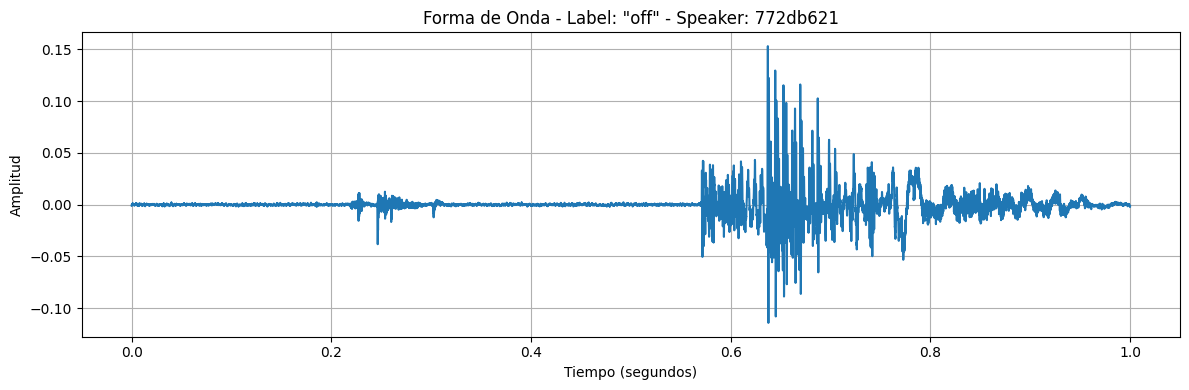


Información del audio:
Label: off
Speaker ID: 772db621
Duración: 1.00 segundos
Sample rate: 16000 Hz
Tamaño del waveform: torch.Size([1, 16000])
Shape of MFCC: torch.Size([1, 13, 101])


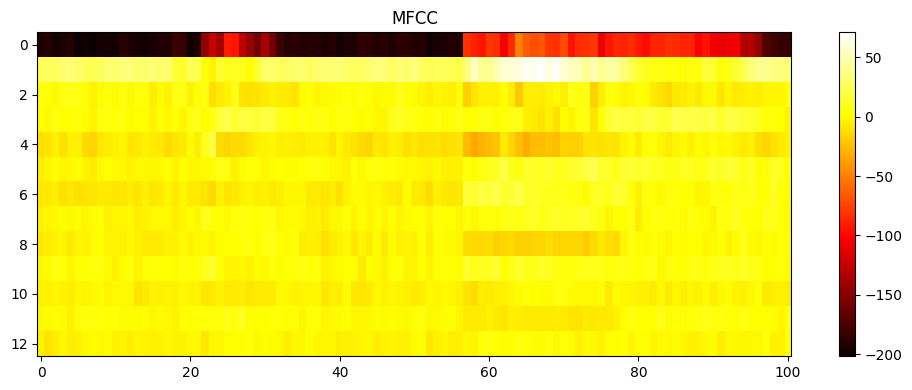

In [12]:

# Crear datasets personalizados
train_dataset = CustomSpeechCommands(ROOT_DIR, TRAIN_LIST)
val_dataset = CustomSpeechCommands(ROOT_DIR, VAL_LIST)
test_dataset = CustomSpeechCommands(ROOT_DIR, TEST_LIST)

print("¡Datasets cargados exitosamente!")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Plotear la primera muestra del train dataset
if len(train_dataset) > 0:
    waveform, sample_rate, label, speaker_id, utterance_number = train_dataset[15000]
    
    # Convertir a numpy y eliminar la dimensión del canal
    wave = waveform.squeeze().numpy()  # .squeeze() elimina dimensiones de tamaño 1
    
    # Crear eje de tiempo en segundos
    duration = len(wave) / sample_rate
    time = np.linspace(0, duration, len(wave))
    
    # Crear el plot
    plt.figure(figsize=(12, 4))
    plt.plot(time, wave)
    plt.title(f'Forma de Onda - Label: "{label}" - Speaker: {speaker_id}')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Información adicional
    print(f"\nInformación del audio:")
    print(f"Label: {label}")
    print(f"Speaker ID: {speaker_id}")
    print(f"Duración: {duration:.2f} segundos")
    print(f"Sample rate: {sample_rate} Hz")
    print(f"Tamaño del waveform: {waveform.shape}")

    # Aplicar transformación MFCC
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=13,
        melkwargs={"n_fft": 320, "hop_length": 160, "n_mels": 23}
    )
    mfcc = mfcc_transform(waveform)
    print(f"Shape of MFCC: {mfcc.shape}")
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc[0].detach().numpy(), cmap='hot', aspect='auto')
    plt.title("MFCC")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [13]:
# Extraer características de los datasets
print("Extrayendo características del conjunto de entrenamiento...")
train_features, train_labels = extract_features(train_dataset)
print("Extrayendo características del conjunto de validación...")
val_features, val_labels = extract_features(val_dataset)
print("Extrayendo características del conjunto de prueba...")
test_features, test_labels = extract_features(test_dataset)
print("¡Extracción de características completada!")
# print(f"Total características de entrenamiento: {len(train_features)}")
print(f"Total características de validación: {len(val_features)}")
print(f"Total características de prueba: {len(test_features)}")

print(f"Ejemplo de feature shape (validación): {val_features[0].shape}, label: {val_labels[0]}")


# Validación
val_df = pd.DataFrame({
    "features": val_features,
    "label": val_labels
})
val_df.to_pickle(os.path.join(ROOT_DIR, "val_features.pkl"))  # se guarda binario

# Test
test_df = pd.DataFrame({
    "features": test_features,
    "label": test_labels
})
test_df.to_pickle(os.path.join(ROOT_DIR, "test_features.pkl"))

# Train
train_df = pd.DataFrame({
    "features": train_features,
    "label": train_labels
})
train_df.to_pickle(os.path.join(ROOT_DIR, "train_features.pkl"))

print("¡Características y etiquetas guardadas en archivos .pkl con pandas!")

# Guardar las características y etiquetas en archivos

print("¡Características y etiquetas guardadas en archivos .npy!")

Extrayendo características del conjunto de entrenamiento...
Procesado 0/32453 muestras
Procesado 2000/32453 muestras
Procesado 4000/32453 muestras
Procesado 6000/32453 muestras
Procesado 8000/32453 muestras
Procesado 10000/32453 muestras
Procesado 12000/32453 muestras
Procesado 14000/32453 muestras
Procesado 16000/32453 muestras
Procesado 18000/32453 muestras
Procesado 20000/32453 muestras
Procesado 22000/32453 muestras
Procesado 24000/32453 muestras
Procesado 26000/32453 muestras
Procesado 28000/32453 muestras
Procesado 30000/32453 muestras
Procesado 32000/32453 muestras
Extrayendo características del conjunto de validación...
Procesado 0/3875 muestras
Procesado 2000/3875 muestras
Extrayendo características del conjunto de prueba...
Procesado 0/4381 muestras
Procesado 2000/4381 muestras
Procesado 4000/4381 muestras
¡Extracción de características completada!
Total características de validación: 3875
Total características de prueba: 4381
Ejemplo de feature shape (validación): (13, 101),

In [14]:
val_df = pd.read_pickle(os.path.join(ROOT_DIR, "val_features.pkl"))
test_df = pd.read_pickle(os.path.join(ROOT_DIR, "test_features.pkl"))
train_df = pd.read_pickle(os.path.join(ROOT_DIR, "train_features.pkl"))

# Ejemplo de acceso a los datos
def ejemplo_acceso_datos(data):
    print(data.head())
    print(data.iloc[0]["features"].shape)  # (13, variable_len)
    print(data.iloc[0]["label"])

ejemplo_acceso_datos(val_df)
ejemplo_acceso_datos(test_df)
ejemplo_acceso_datos(train_df)

                                            features     label
0  [[-200.41225, -193.5304, -197.94473, -196.0375...  backward
1  [[-186.58188, -183.57593, -190.44763, -189.259...  backward
2  [[-182.03479, -186.18878, -181.24742, -179.643...  backward
3  [[-187.35686, -187.33795, -194.23389, -189.787...  backward
4  [[-194.89632, -189.55576, -188.49474, -187.230...  backward
(13, 101)
backward
                                            features     label
0  [[-263.5697, -260.35373, -250.68332, -236.1353...  backward
1  [[-251.97493, -250.5761, -249.29857, -251.7264...  backward
2  [[-211.1336, -218.32874, -221.01534, -220.7416...  backward
3  [[-258.77133, -256.88095, -254.57016, -254.313...  backward
4  [[-261.5508, -259.5515, -263.58392, -259.446, ...  backward
(13, 101)
backward
                                            features     label
0  [[-85.577415, -94.74945, -91.251366, -90.17329...  backward
1  [[-202.7281, -206.59384, -199.62689, -198.2852...  backward
2  [[-221.05798, 

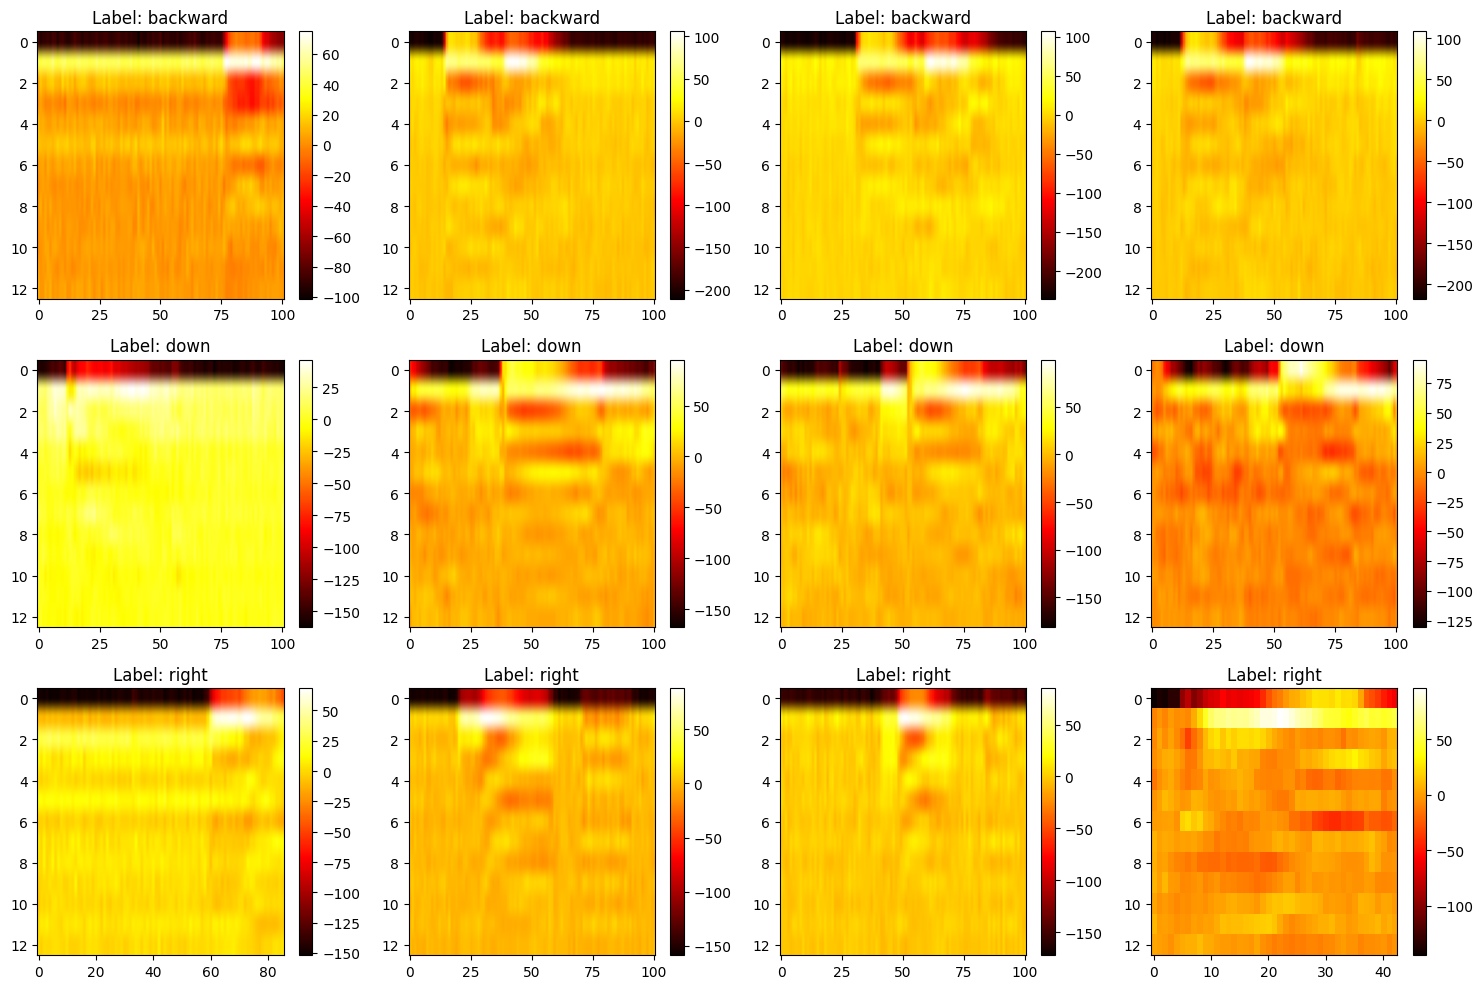

In [23]:
# Subplot para comparar MFCC entre diferentes muestras

indices = list(range(4)) + list(range(1000, 1004)) + list(range(20000, 20004))

plt.figure(figsize=(15, 10))

for j, idx in enumerate(indices):
    plt.subplot(3, 4, j+1)  # 3 filas, 4 columnas
    plt.imshow(train_df.iloc[idx]["features"], cmap='hot', aspect='auto')
    plt.title(f"Label: {train_df.iloc[idx]['label']}")
    plt.colorbar()

plt.tight_layout()
plt.show()


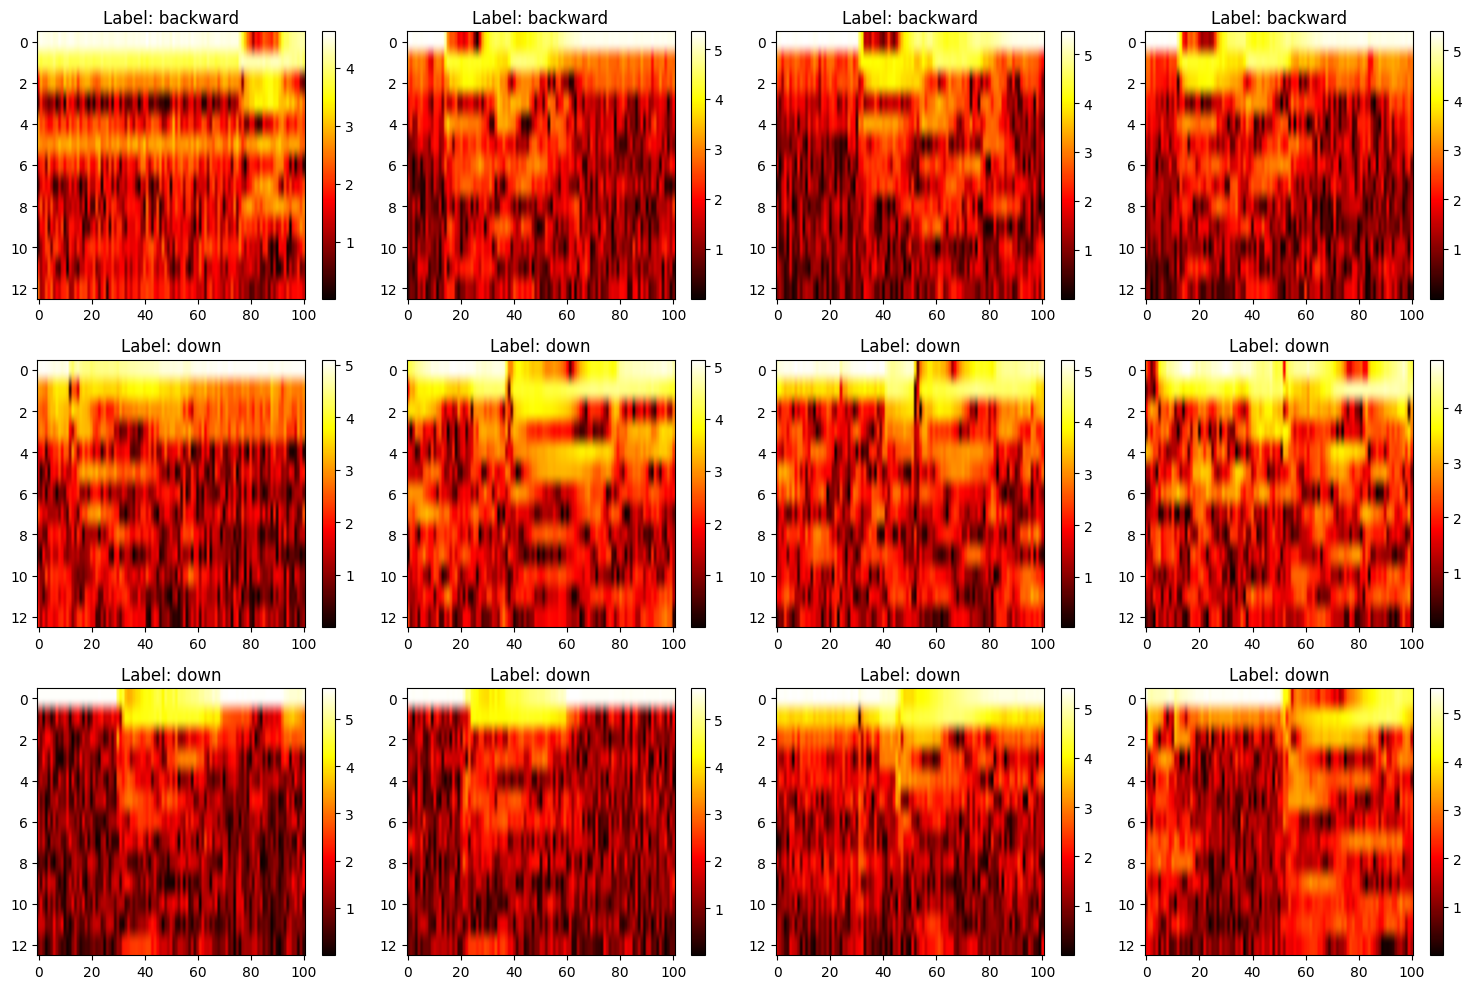

In [24]:
indices = list(range(4)) + list(range(1000, 1004)) + list(range(2000, 2004))

plt.figure(figsize=(15, 10))

for j, idx in enumerate(indices):
    mfcc = train_df.iloc[idx]["features"]
    mfcc_log = np.log1p(np.abs(mfcc))  # log(1+x) evita problemas con ceros

    plt.subplot(3, 4, j+1)
    plt.imshow(mfcc_log, cmap='hot', aspect='auto')
    plt.title(f"Label: {train_df.iloc[idx]['label']}")
    plt.colorbar()

plt.tight_layout()
plt.show()